In [5]:
# encoding: UTF-8
import warnings
warnings.filterwarnings("ignore")
import pandas as pd  
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import akshare as ak
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
StockPrices = pd.DataFrame()

In [6]:
# 设置股票数据的开始和结束的时间
code='000001'
start='20170101'
end='20190618'


In [7]:
stock_df = ak.stock_zh_a_hist(
                        symbol=code,
                        period="daily",
                        start_date=start,
                        end_date=end,
                        adjust="hfq")
stock_df

,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2017-01-03,1513.44,1521.56,1524.82,1510.19,459840,420595184.0,0.97,0.64,9.75,0.31
1,2017-01-04,1519.94,1521.56,1524.82,1518.31,449330,411503440.0,0.43,0.00,0.00,0.31
2,2017-01-05,1523.19,1523.19,1524.82,1519.94,344373,315769696.0,0.32,0.11,1.63,0.24
3,2017-01-06,1523.19,1516.69,1523.19,1513.44,358154,327176432.0,0.64,-0.43,-6.50,0.24
4,2017-01-09,1516.69,1519.94,1523.19,1513.44,361082,329994608.0,0.64,0.21,3.25,0.21
...,...,...,...,...,...,...,...,...,...,...,...
592,2019-06-12,2133.32,2123.57,2138.19,2102.44,657310,825178000.0,1.67,-0.61,-13.00,0.38
593,2019-06-13,2118.69,2126.82,2141.44,2100.81,530000,666277696.0,1.91,0.15,3.25,0.31
594,2019-06-14,2126.82,2110.56,2143.07,2104.06,483192,606815216.0,1.83,-0.76,-16.26,0.28
595,2019-06-17,2108.94,2139.82,2159.32,2108.94,619816,786223584.0,2.39,1.39,29.26,0.36


In [8]:
df = pd.DataFrame()
df['close'] = stock_df['收盘']
df['date'] = pd.to_datetime(stock_df['日期'])
df = df.set_index('date')
df = df[~df.index.duplicated()]
StockPrices[code] = df['close']
StockPrices[code]

date
2017-01-03    1521.56
2017-01-04    1521.56
2017-01-05    1523.19
2017-01-06    1516.69
2017-01-09    1519.94
               ...   
2019-06-12    2123.57
2019-06-13    2126.82
2019-06-14    2110.56
2019-06-17    2139.82
2019-06-18    2160.95
Name: 000001, Length: 597, dtype: float64

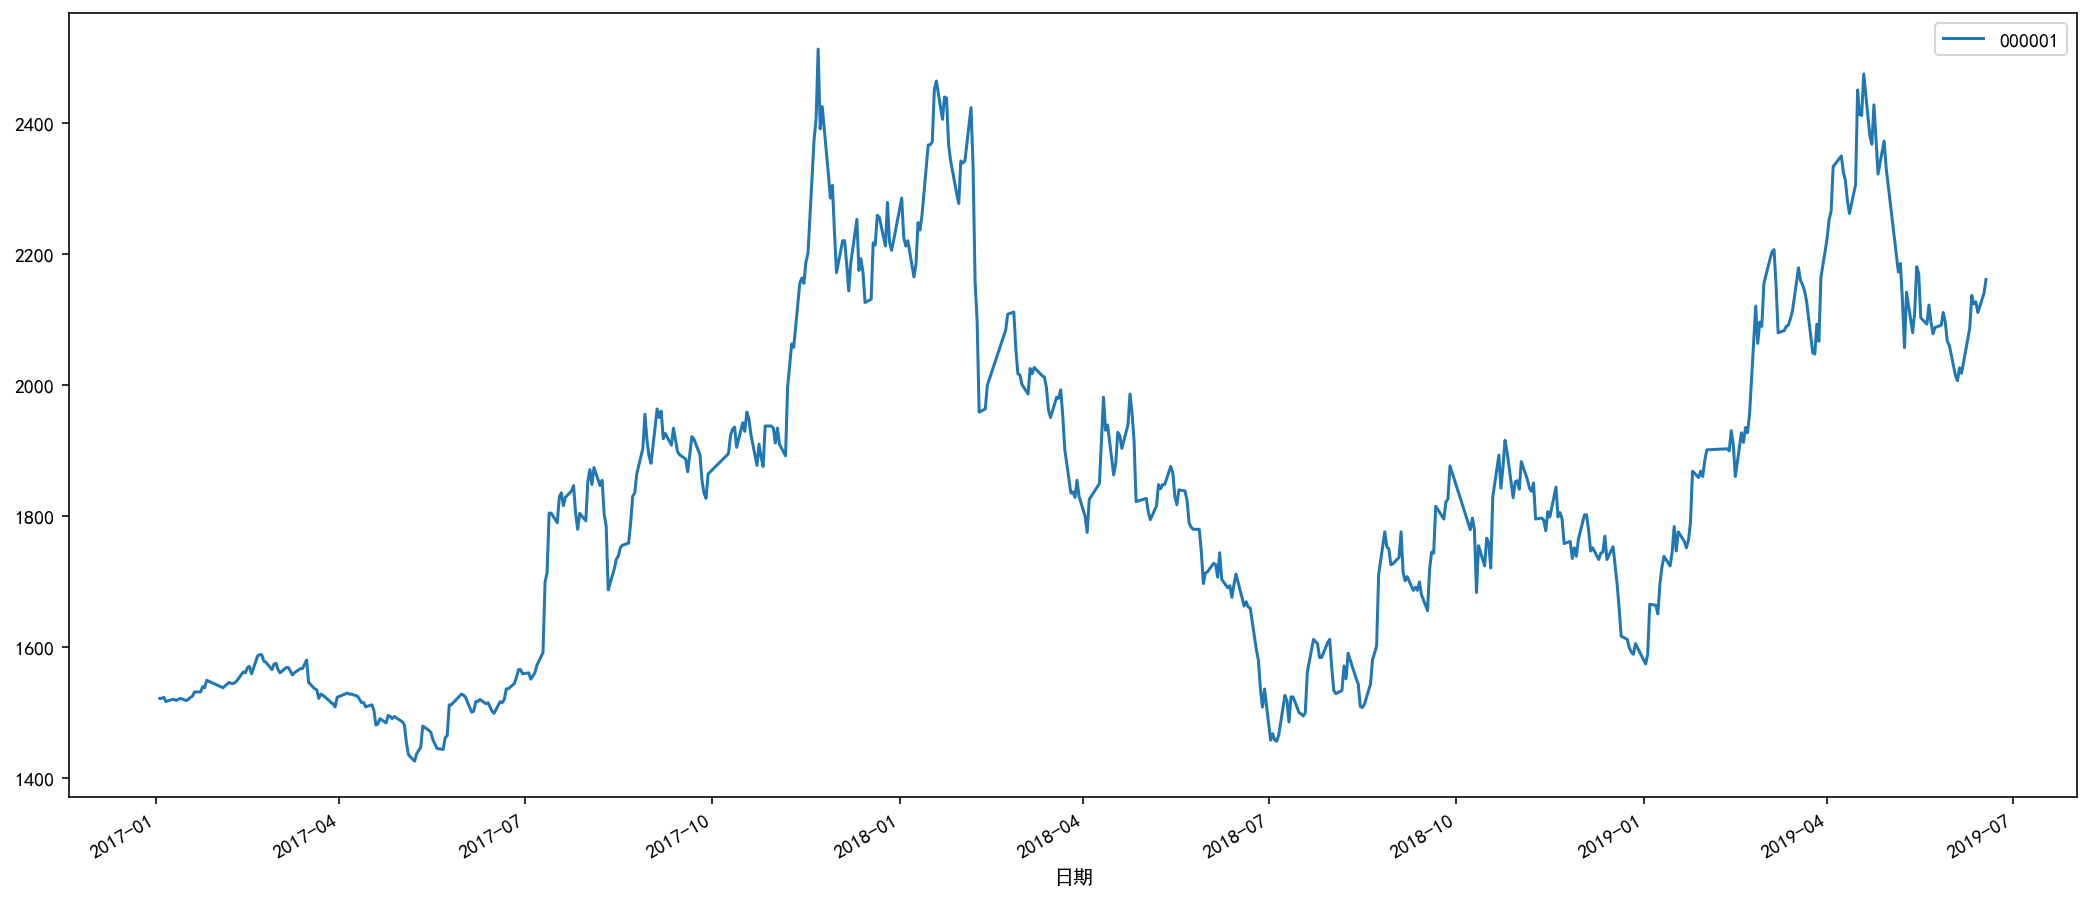

In [9]:
StockPrices[code].plot(figsize=(18,8),label=code)
plt.xlabel('日期')
plt.legend()
plt.show()

In [10]:
# 增加一列'Returns', 存储每日的收益率
StockPrices["Log"+code] = np.log(StockPrices[code])
StockPrices['LogReturns'] = StockPrices["Log"+code].diff(1)
StockPrices['ReturnsPCT'] = StockPrices[code].pct_change()
print('指数收益之和 %s' % round(np.exp(StockPrices["LogReturns"].sum()),4))
print('算数收益之和 %s' % str(round(StockPrices[code][-1]/StockPrices[code][0],4)))

指数收益之和 1.4202
算数收益之和 1.4202


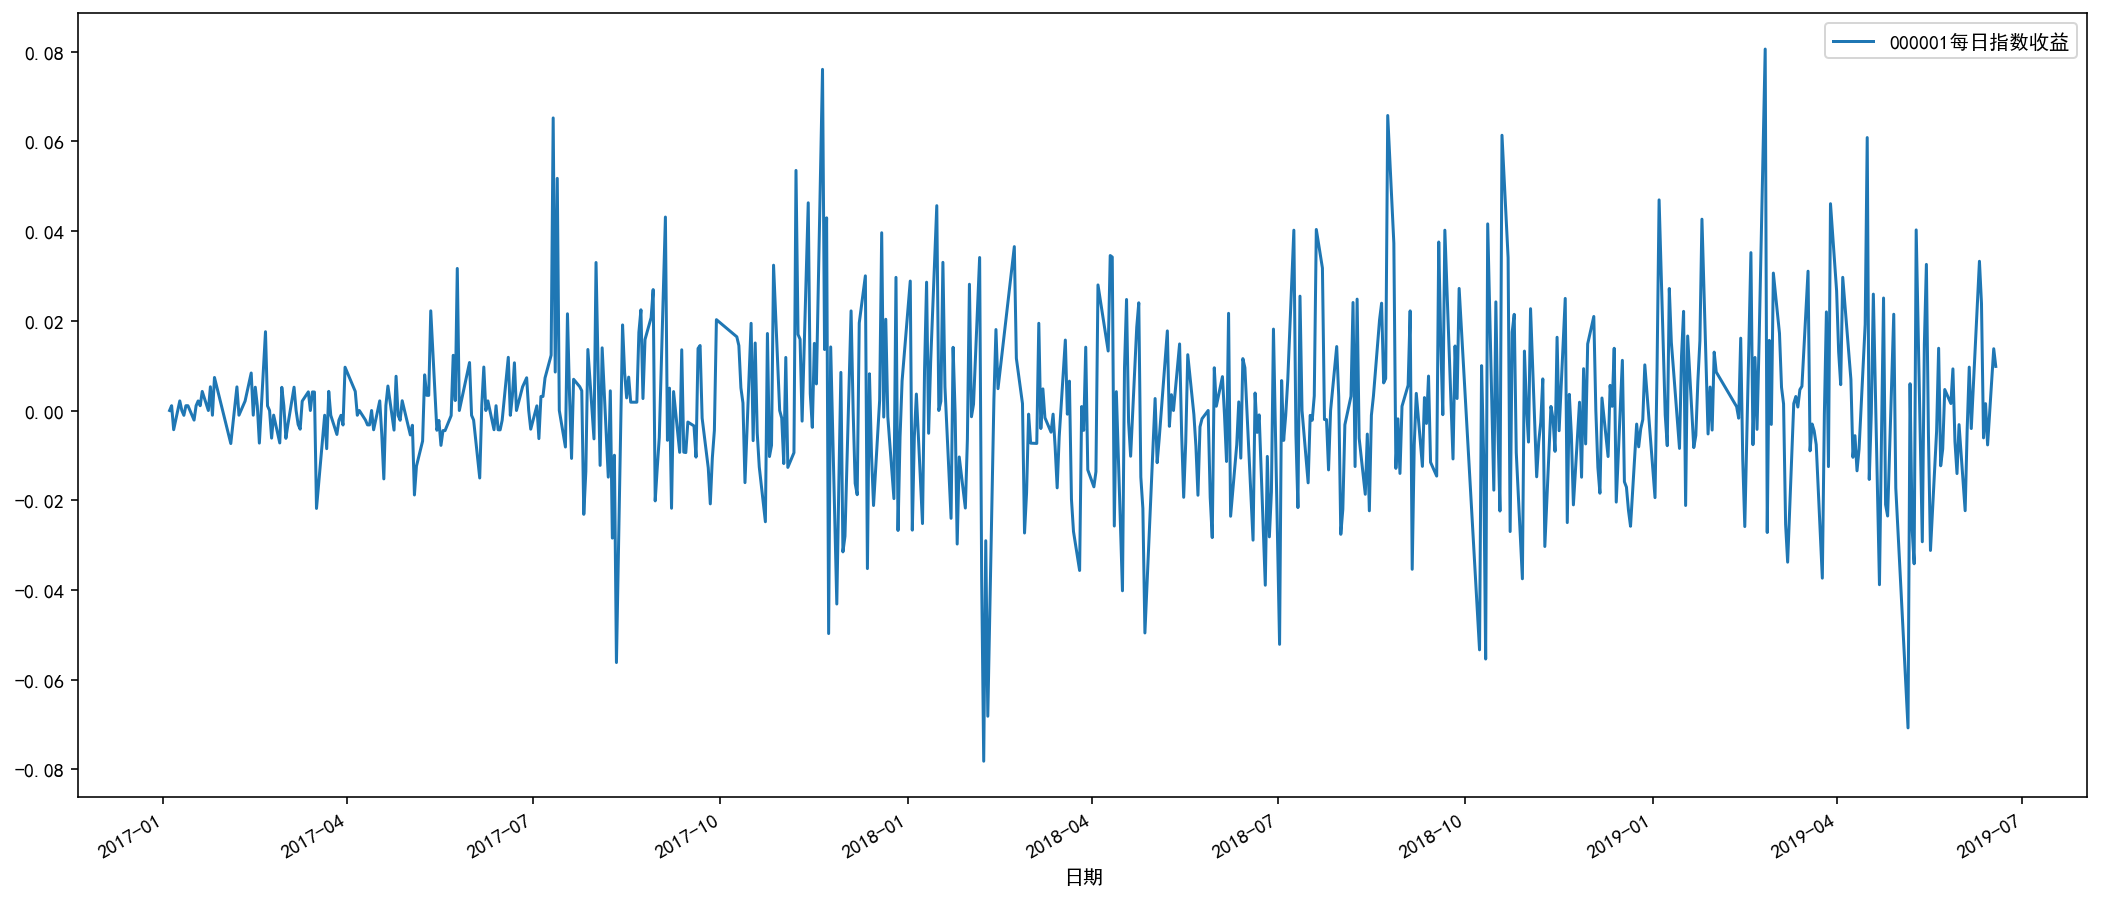

In [11]:
clean_returns = StockPrices['LogReturns'].dropna()
#绘图
clean_returns.plot(figsize=(18,8),label=code+'每日指数收益')
plt.legend()
plt.xlabel('日期')
plt.show()

In [12]:
# encoding: UTF-8
import numpy as np
# 计算标准差 
sigma_daily = np.std(clean_returns) 
print("标准差: ", round(sigma_daily,4) )
# 计算方差 
variance_daily = sigma_daily ** 2 
print("方差: ", round(variance_daily,4))

标准差:  0.019
方差:  0.0004


In [13]:
# 计算年化标准差 
sigma_annualized = sigma_daily *np.sqrt(252)
print("年化标准差:", round(sigma_annualized,4)) 
# 计算年化方差 
variance_annualized = sigma_annualized ** 2 
print("年化方差 :", round(variance_annualized,4))

年化标准差: 0.3022
年化方差 : 0.0913


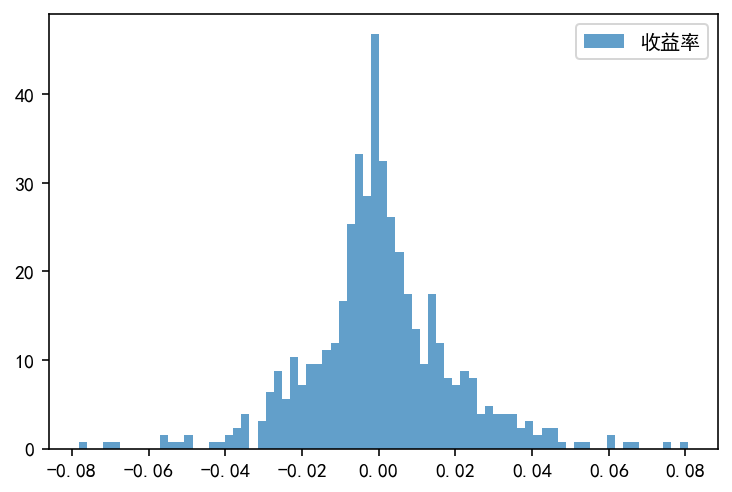

In [14]:
# 绘制收益的概率密度分布图
plt.hist(clean_returns, bins=75, alpha=0.7, density=True, label='收益率')
# 增加图例说明
plt.legend()
# 绘图
plt.show()

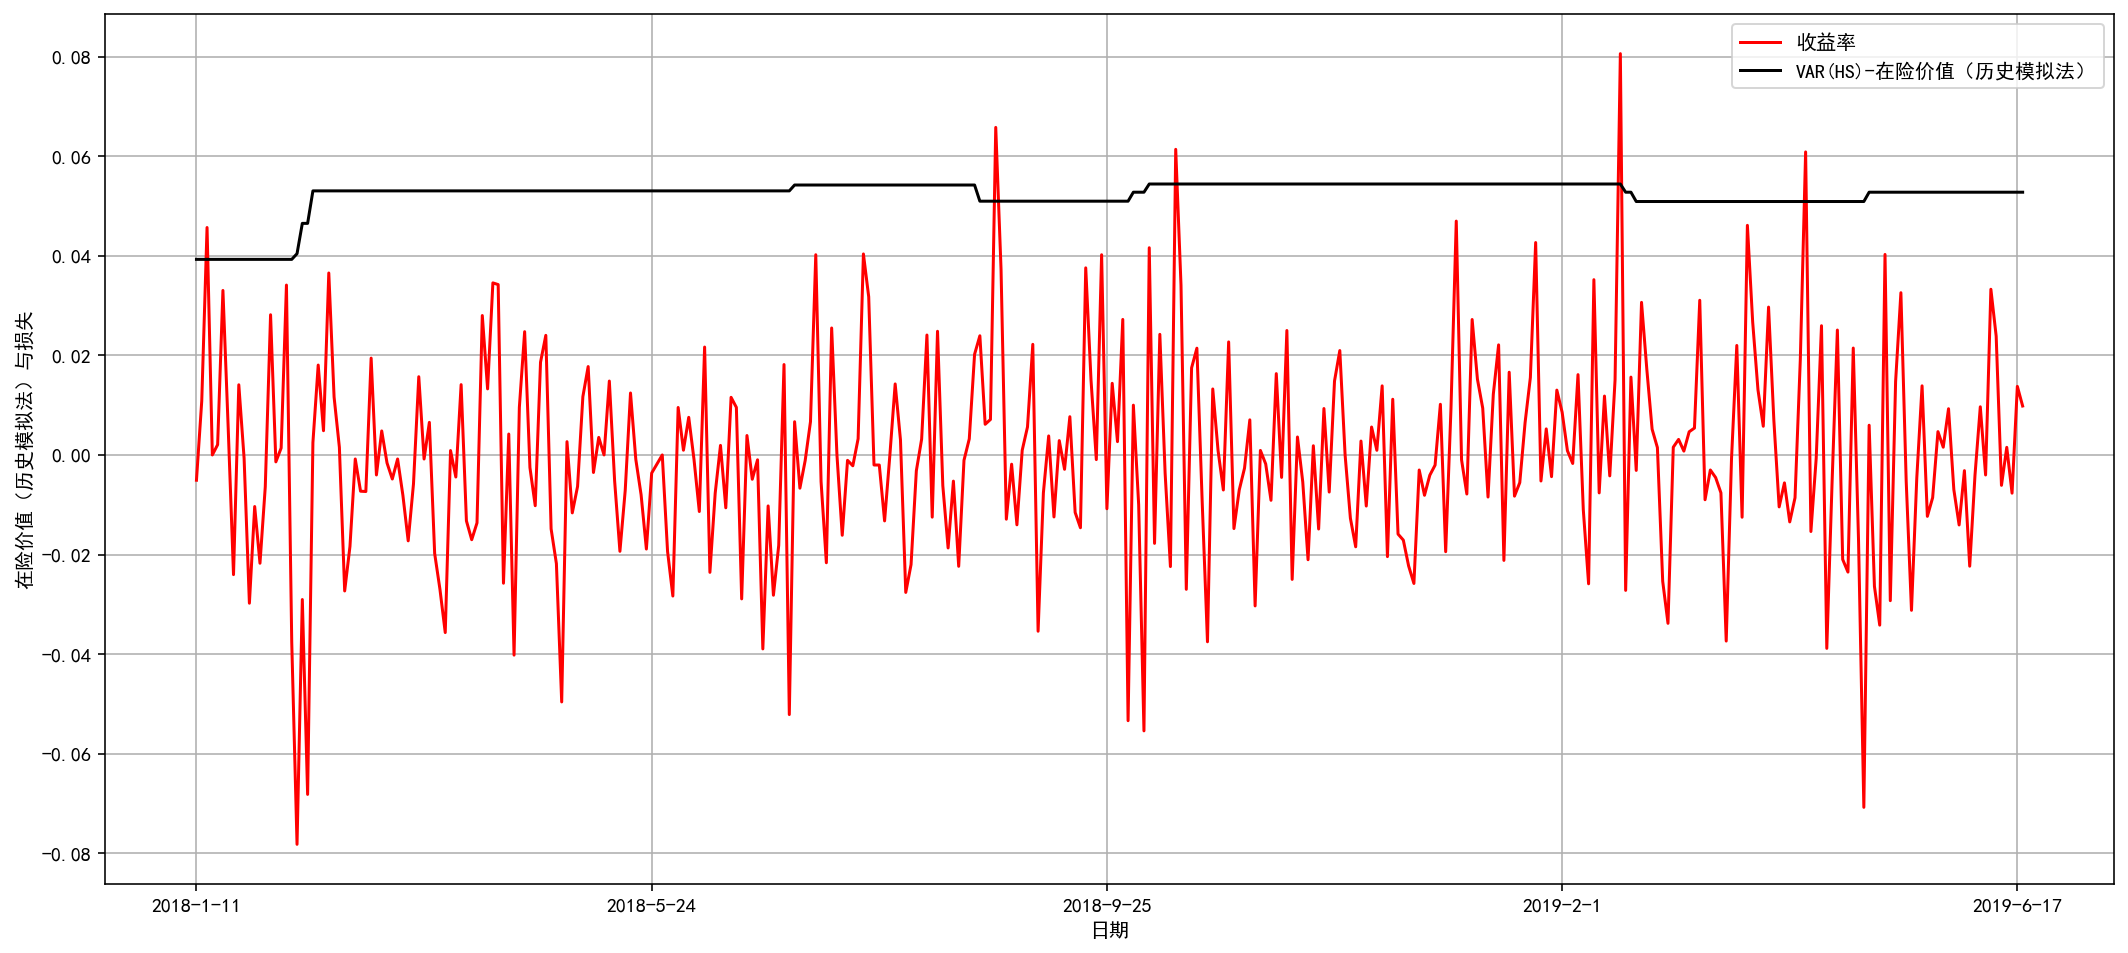

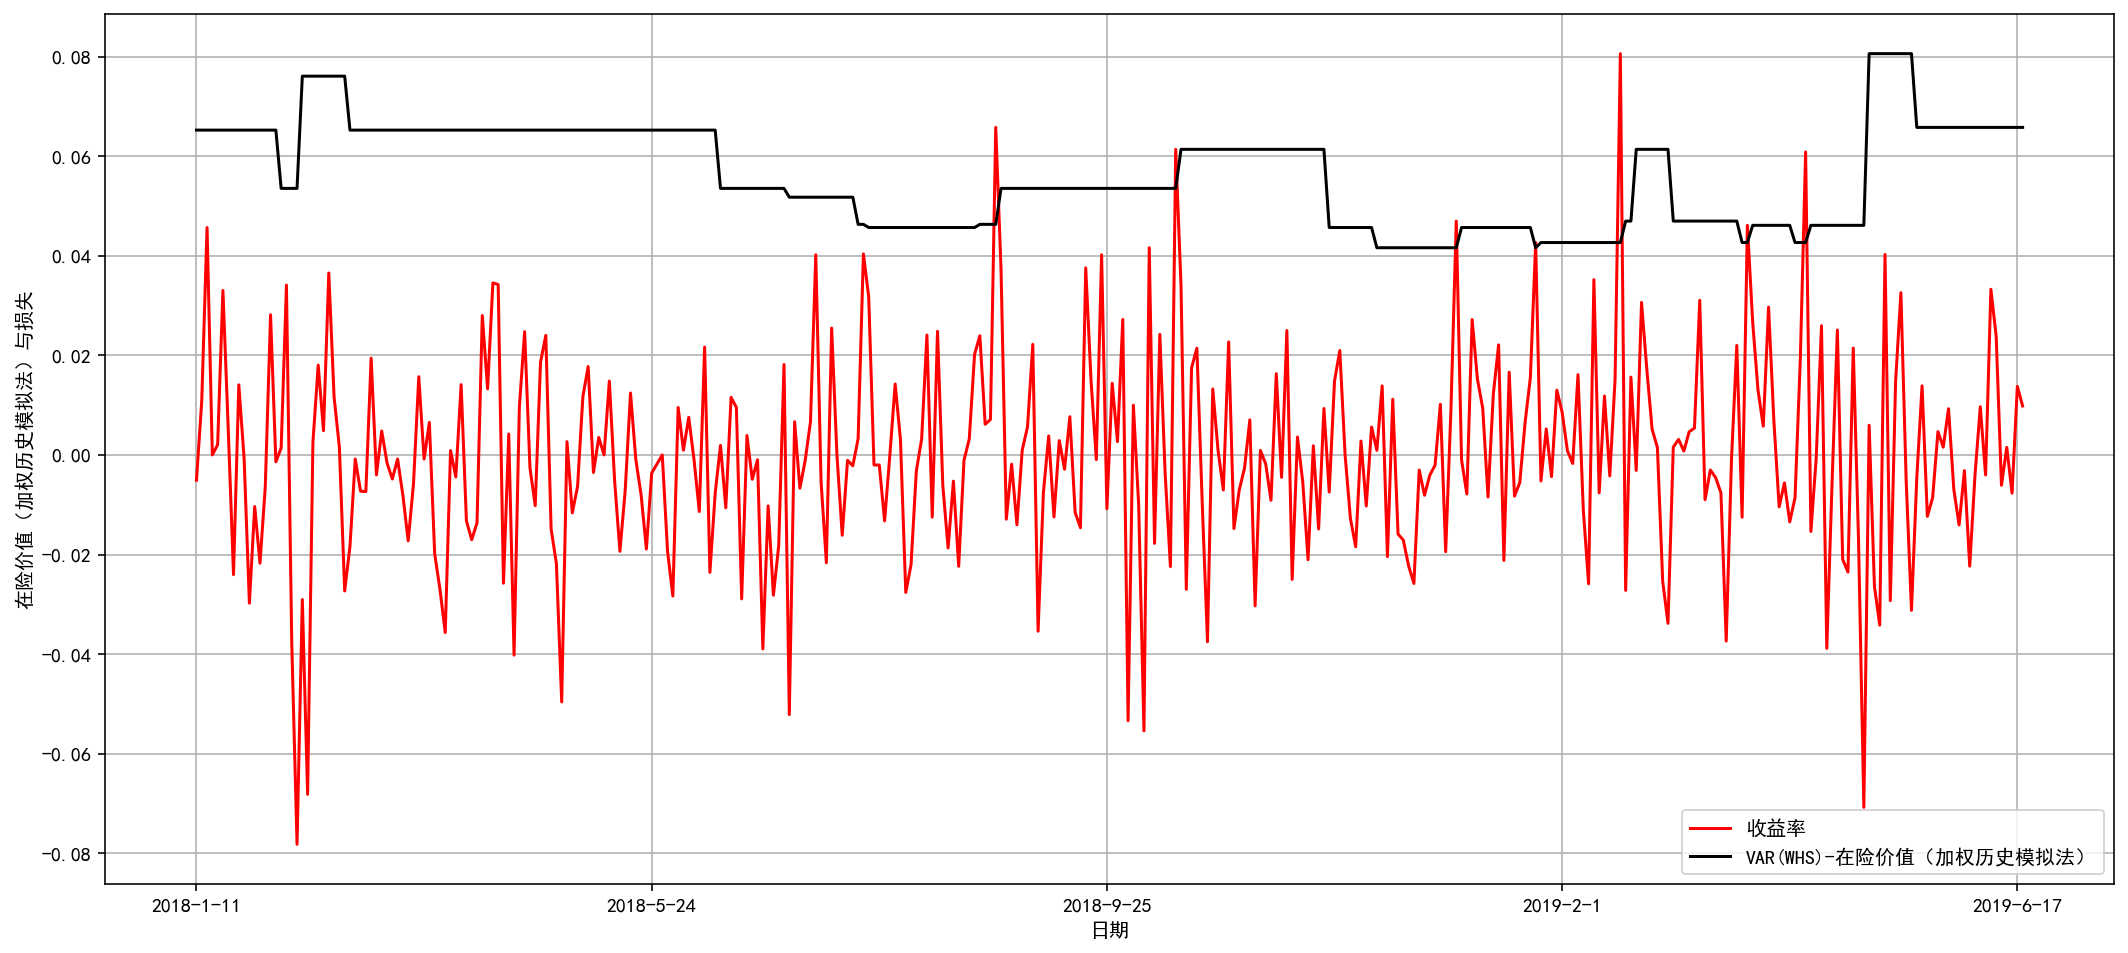

In [17]:
data1 = pd.DataFrame()
data1['return'] = StockPrices["LogReturns"]
data1['Loss'] = data1['return']
data1['VAR'] = np.nan
data1 = data1.reset_index()

# HS和WHS
p = 1 # 1%
window = 250
eta = 0.99
weights = eta ** (np.arange(250,0,-1) - 1)*(1 - eta)/(1 - eta** window) 

for i in range(window + 1,data1.shape[0]):
    datause = data1.loc[i - window:i-1,'return']
    data1.loc[i,'VAR'] =  -np.percentile(datause,p)
    data1.loc[i,'VAR_WHS'] = np.sort(datause)[np.min(np.where(weights[np.argsort(-datause)].cumsum()> 0.99))]

# 作图
data11 = data1.loc[window+1:,:].copy()
data11 = data11.reset_index(drop = True)
X = np.arange(data11.shape[0])
xticklabel = data11.loc[:,'date'].apply(lambda x:str(x.year) + '-' +str(x.month) + '-' +str(x.day))
xticks = np.arange(0,data11.shape[0]+1,np.int((data11.shape[0]+1)/4))


plt.figure(figsize=(18,8))
SP = plt.axes()
SP.plot(X,data11['Loss'], color = 'red',label = '收益率')     
SP.plot(X,data11.VAR,color = 'black',label = 'VAR(HS)-在险价值（历史模拟法）')   
SP.set_xticks(xticks)
SP.set_xticklabels(xticklabel[xticks])
plt.xlabel('日期')
plt.ylabel('在险价值（历史模拟法）与损失')
plt.grid()
plt.legend();
plt.figure(figsize=(18,8))
SP = plt.axes()
SP.plot(X,data11['Loss'], color = 'red',label = '收益率')     
SP.plot(X,data11.VAR_WHS,color = 'black',label = 'VAR(WHS)-在险价值（加权历史模拟法）')   
SP.set_xticks(xticks)
SP.set_xticklabels(xticklabel[xticks])
plt.xlabel('日期')
plt.ylabel('在险价值（加权历史模拟法）与损失')
plt.grid()
plt.legend();

In [18]:
#假设投入金融为一万美圆（$10000),那么最后一日，概率为1%的最大损失是
VARbyDollor = 10000.0*(1-np.exp(-data1['VAR']))
WVARbyDollor = 10000.0*(1-np.exp(-data1['VAR_WHS']))
print("在险价值, %s; 加权在险价值, %s" %(np.array(VARbyDollor)[-1] , (np.array(WVARbyDollor)[-1])))

在险价值, 513.9271438386561; 加权在险价值, 636.5629110039462


array([<AxesSubplot:xlabel='日期'>, <AxesSubplot:xlabel='日期'>,
       <AxesSubplot:xlabel='日期'>], dtype=object)

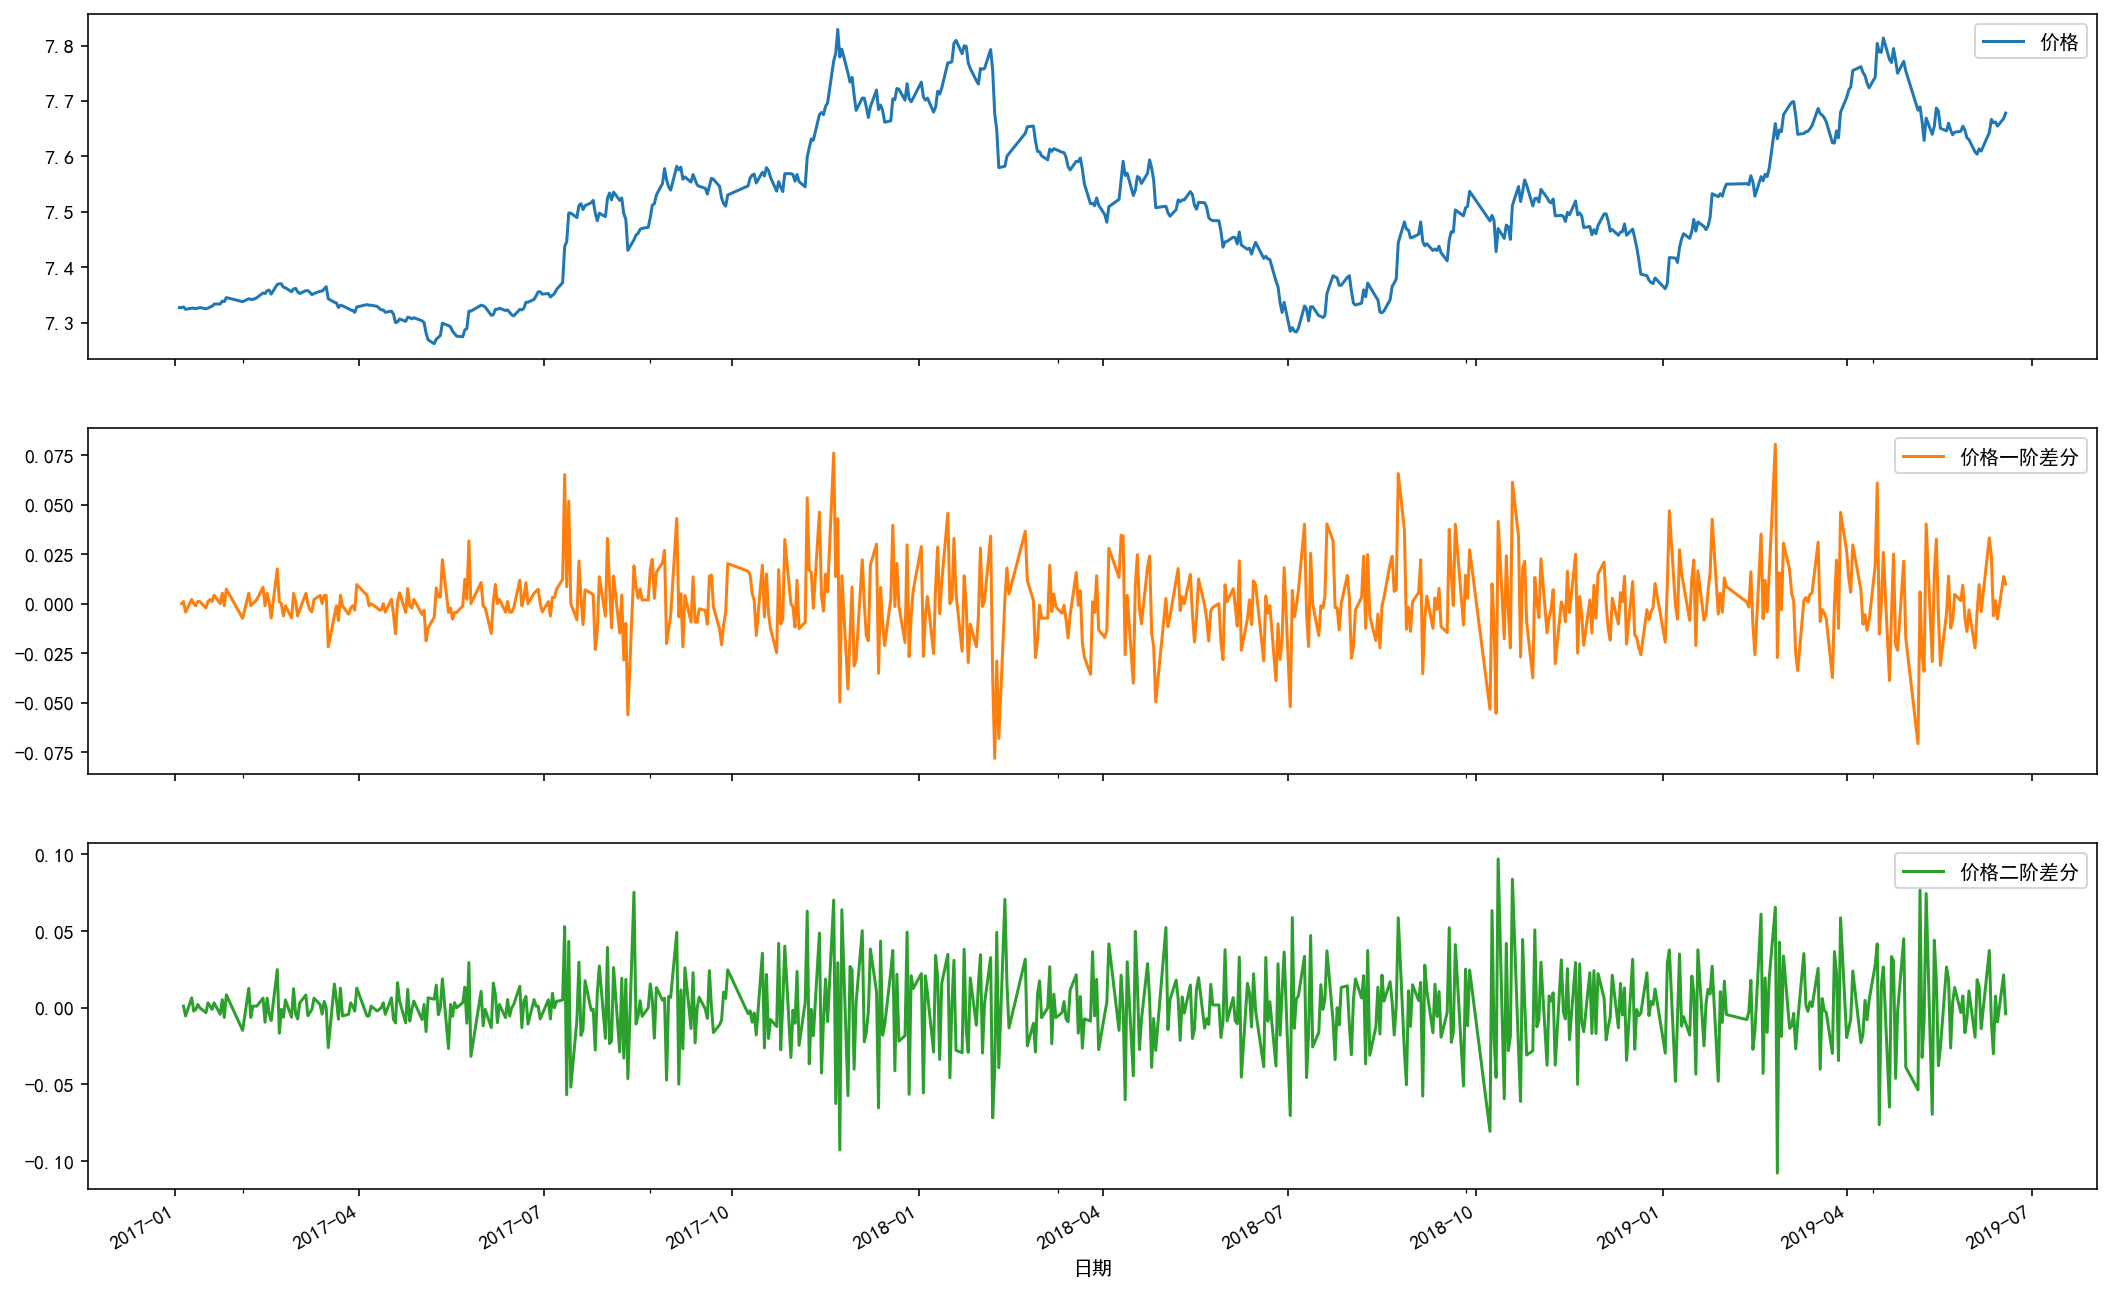

In [19]:
"""
均值和方差：平稳时间序列粗略地讲，一个时间序列，如果均值没有系统的变化（无趋势）、
方差没有系统变化，且严格消除了周期性变化，就称之是平稳的。
"""
IndexData = pd.DataFrame()
IndexData['价格'] = StockPrices['Log'+code]
IndexData['价格一阶差分'] = IndexData['价格'].diff()  # 1阶差分处理
IndexData['价格二阶差分'] = IndexData['价格一阶差分'].diff()  # 2阶差分处理
IndexData.index.name='日期'
IndexData.plot(subplots=True,figsize=(18,12))

In [21]:
from scipy import  stats
import statsmodels.api as sm  # 统计相关的库

data = IndexData['价格一阶差分'].dropna() 
m = 10 # 我们检验10个自相关系数

acf,q,p = sm.tsa.acf(data,nlags=m,qstat=True)  ## 计算自相关系数 及p-value
out = np.c_[range(1,11), acf[1:11], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output
#如果AC存在大于0的值，可以理解非平稳,
#如下，都是0附件活动，可以理解是AR自回归数列

,AC,Q,P-value
lag,,,
1.0,0.018181,0.197997,0.656343
2.0,0.036729,1.007446,0.604277
3.0,0.105358,7.679011,0.053133
4.0,-0.081771,11.704599,0.019689
5.0,-0.089238,16.506996,0.005536
6.0,-0.021240,16.779509,0.010129
7.0,0.031965,17.397790,0.015004
8.0,-0.101123,23.596101,0.002678
9.0,0.110195,30.968949,0.000300


In [22]:
from statsmodels.tsa.stattools import kpss
temp=data.copy()
kpss(temp)

C:\Users\Administrator\anaconda3\envs\jupyter_lab_demo\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.07760023992421153,
 0.1,
 2,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [23]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljbox
ljbox(temp, lags=1)

,lb_stat,lb_pvalue
1,0.197997,0.656343


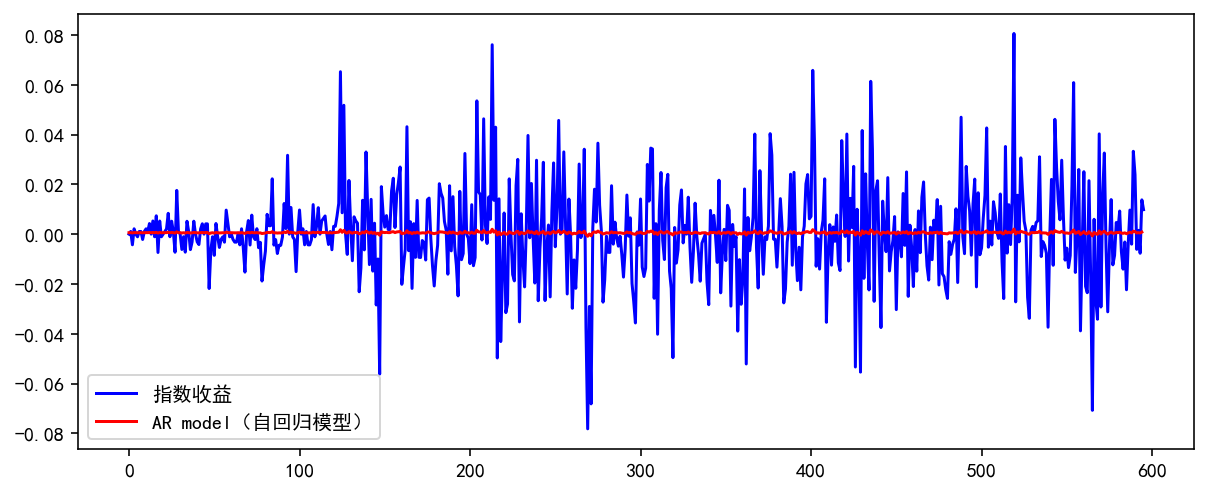

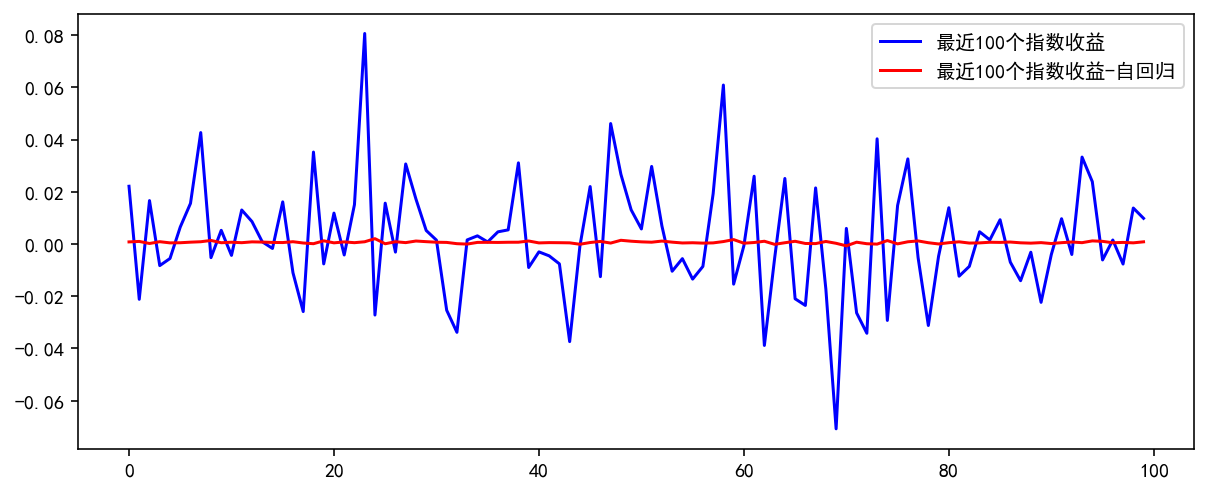

In [37]:
import statsmodels
temp = np.array(data) # 载入收益率序列
model = statsmodels.tsa.ar_model.AutoReg(endog=temp, lags=1)   
results_AR = model.fit()  
# print(len(temp))
# print(len(results_AR.fittedvalues))
plt.figure(figsize=(10,4))
plt.plot(temp[-2500:],'b',label='指数收益')
plt.plot(results_AR.fittedvalues[-2500:], 'r',label='AR model（自回归模型）')
plt.legend()
plt.show()
plt.figure(figsize=(10,4))
plt.plot(temp[-100:],'b',label='最近100个指数收益')
plt.plot(results_AR.fittedvalues[-100:], 'r',label='最近100个指数收益-自回归')
plt.legend()
plt.show()

In [38]:
print(len(results_AR.roots))
results_AR.roots

1


array([54.98110001])

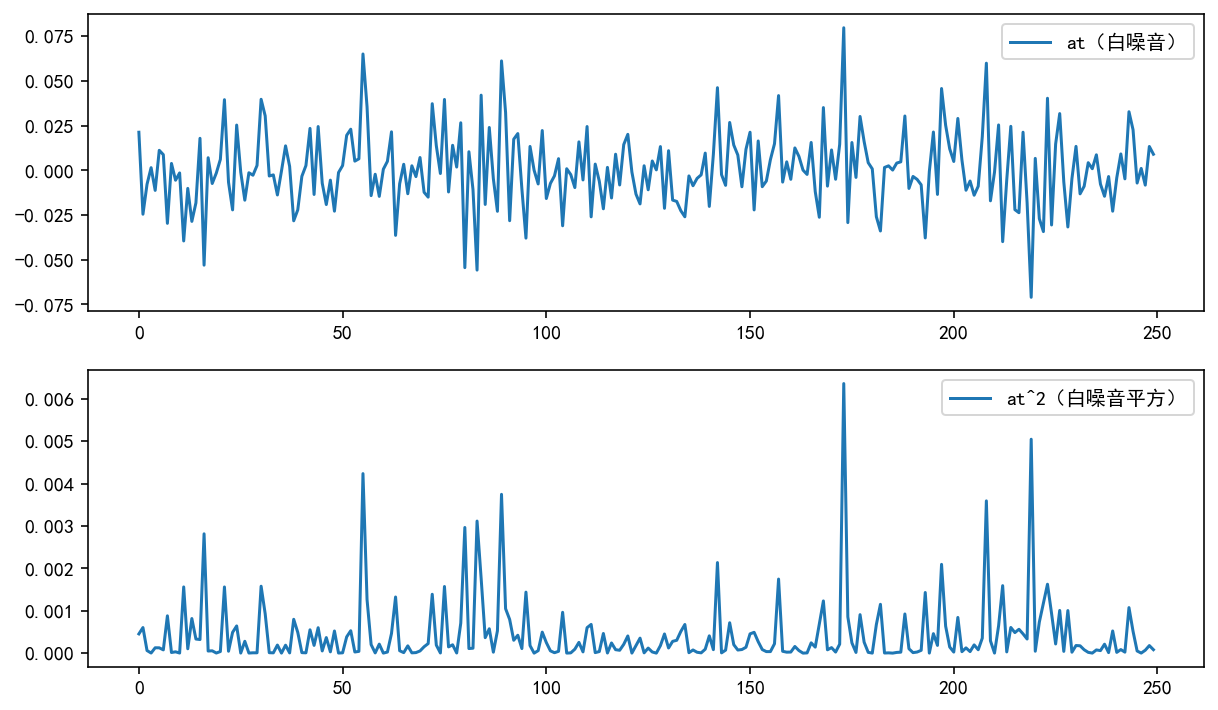

In [39]:
at = temp[-250:] -  results_AR.fittedvalues[-250:]
at2 = np.square(at)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(at,label = 'at（白噪音）')
plt.legend()
plt.subplot(212)
plt.plot(at2,label='at^2（白噪音平方）')
plt.legend(loc=0);
#可以看出新息序列a，存在聚集情况，虽然不相关，但是不独立。

In [40]:
m = 10# 我们检验25个自相关系数
acf,q,p = sm.tsa.acf(at2,nlags=m,qstat=True)  ## 计算自相关系数 及p-value
out = np.c_[range(1,11), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output

,AC,Q,P-value
lag,,,
1.0,0.042564,0.458384,0.498380
2.0,-0.071531,1.758191,0.415158
3.0,0.026515,1.937517,0.585476
4.0,0.093156,4.159966,0.384790
5.0,0.091377,6.307054,0.277477
6.0,0.011771,6.342830,0.385901
7.0,0.028026,6.546462,0.477576
8.0,0.033456,6.837850,0.554224
9.0,0.074759,8.298840,0.504333


In [42]:
from arch import arch_model
am = arch_model(temp,mean='AR',lags=8,vol='ARCH',p=4) ;
res = am.fit()
res.summary()

Iteration:      1,   Func. Count:     16,   Neg. LLF: 101470.17341083204
Iteration:      2,   Func. Count:     37,   Neg. LLF: 10388.399165748877
Iteration:      3,   Func. Count:     56,   Neg. LLF: -247.3817291429021
Iteration:      4,   Func. Count:     74,   Neg. LLF: -1134.0275377781509
Iteration:      5,   Func. Count:     91,   Neg. LLF: -627.0371246532678
Iteration:      6,   Func. Count:    107,   Neg. LLF: -1184.6882839292468
Iteration:      7,   Func. Count:    124,   Neg. LLF: -582.926035838171
Iteration:      8,   Func. Count:    142,   Neg. LLF: -911.4939967885609
Iteration:      9,   Func. Count:    159,   Neg. LLF: -214.35598143364737
Iteration:     10,   Func. Count:    176,   Neg. LLF: 452822.3604161215
Iteration:     11,   Func. Count:    193,   Neg. LLF: 374181.3019353037
Iteration:     12,   Func. Count:    211,   Neg. LLF: -1337.6924725842873
Iteration:     13,   Func. Count:    228,   Neg. LLF: -1339.8590937303923
Iteration:     14,   Func. Count:    245,   Neg. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - ARCH Model Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.037
Mean Model:                        AR   Adj. R-squared:                  0.024
Vol Model:                       ARCH   Log-Likelihood:                1517.54
Distribution:                  Normal   AIC:                          -3007.08
Method:            Maximum Likelihood   BIC:                          -2945.80
                                        No. Observations:                  588
Date:                Mon, Feb 28 2022   Df Residuals:                      579
Time:                        15:48:44   Df Model:                            9
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      5.8554e-04  7.085e-04      0.826      0.409 [-8.031e-04,1.974e-03]
y[1]           0.0420  7.134e-02      0.588      0.556   [-9.787e-02,  0.182]
y[2]           0.0111  6.299e-02      0.176      0.860      [ -0.112,  0.135]
y[3]           0.1056  5.002e-02      2.110  3.484e-02    [7.515e-03,  0.204]
y[4]          -0.0987  8.437e-02     -1.169      0.242    [ -0.264,6.670e-02]
y[5]          -0.0976  5.949e-02     -1.640      0.101    [ -0.214,1.902e-02]
y[6]          -0.0243  4.868e-02     -0.499      0.618    [ -0.120,7.113e-02]
y[7]           0.0580  4.978e-02      1.165      0.244   [-3.957e-02,  0.156]
y[8]          -0.1305  7.270e-02     -1.795  7.259e-02    [ -0.273,1.196e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.0876e-04  5.736e-05      3.639  2.735e-04 [9.633e-05,3.212e-04]
alpha[1]       0.2103      0.210      1.001      0.317     [ -0.202,  0.622]
alpha[2]       0.0586  4.226e-02      1.386      0.166  [-2.425e-02,  0.141]
alpha[3]       0.0431  8.395e-02      0.513      0.608     [ -0.121,  0.208]
alpha[4]       0.1467  8.658e-02      1.695  9.014e-02  [-2.297e-02,  0.316]
============================================================================

Covariance estimator: robust
"""

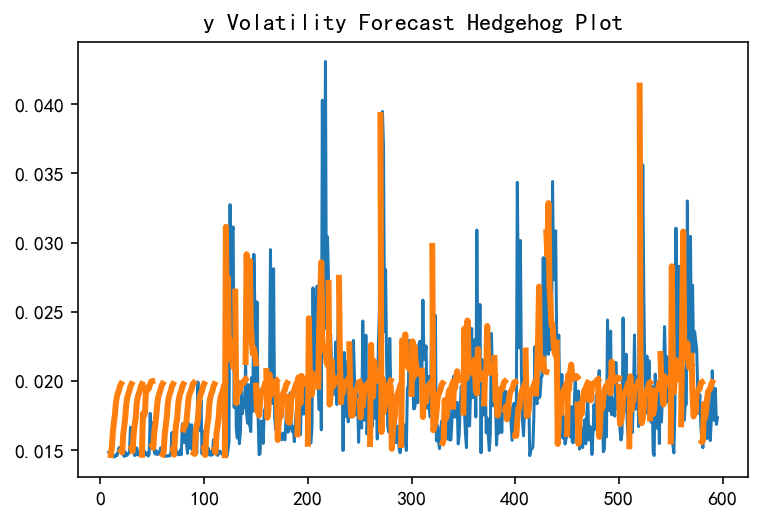

In [43]:
fig = res.hedgehog_plot();

In [44]:
GARCH_am = arch_model(temp,mean='AR',lags=8,vol='GARCH') 
GARCH_res = GARCH_am.fit()
GARCH_res.summary()

Iteration:      1,   Func. Count:     14,   Neg. LLF: 203832284.38373542
Iteration:      2,   Func. Count:     33,   Neg. LLF: -1541.3177312733128
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1541.317728014467
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.041
Mean Model:                        AR   Adj. R-squared:                  0.028
Vol Model:                      GARCH   Log-Likelihood:                1541.32
Distribution:                  Normal   AIC:                          -3058.64
Method:            Maximum Likelihood   BIC:                          -3006.11
                                        No. Observations:                  588
Date:                Mon, Feb 28 2022   Df Residuals:                      579
Time:                        15:49:05   Df Model:                            9
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      4.7154e-04  6.307e-04      0.748      0.455 [-7.646e-04,1.708e-03]
y[1]           0.0193  4.517e-02      0.428      0.669   [-6.922e-02,  0.108]
y[2]           0.0495  3.298e-02      1.502      0.133   [-1.511e-02,  0.114]
y[3]           0.1076  4.739e-02      2.271  2.312e-02    [1.476e-02,  0.201]
y[4]          -0.0994  4.636e-02     -2.145  3.194e-02   [ -0.190,-8.587e-03]
y[5]          -0.0875  5.004e-02     -1.749  8.022e-02    [ -0.186,1.054e-02]
y[6]          -0.0191  4.311e-02     -0.444      0.657    [ -0.104,6.535e-02]
y[7]           0.0620  4.130e-02      1.500      0.134   [-1.898e-02,  0.143]
y[8]          -0.0906  4.531e-02     -2.000  4.552e-02   [ -0.179,-1.808e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      7.0439e-06  2.536e-11  2.777e+05      0.000 [7.044e-06,7.044e-06]
alpha[1]       0.0500  4.070e-02      1.229      0.219  [-2.977e-02,  0.130]
beta[1]        0.9300  4.329e-02     21.485 2.154e-102     [  0.845,  1.015]
============================================================================

Covariance estimator: robust
"""

In [45]:
GARCH_res.params

Const       0.000472
y[1]        0.019309
y[2]        0.049524
y[3]        0.107639
y[4]       -0.099446
y[5]       -0.087533
y[6]       -0.019142
y[7]        0.061968
y[8]       -0.090607
omega       0.000007
alpha[1]    0.050000
beta[1]     0.930000
Name: params, dtype: float64

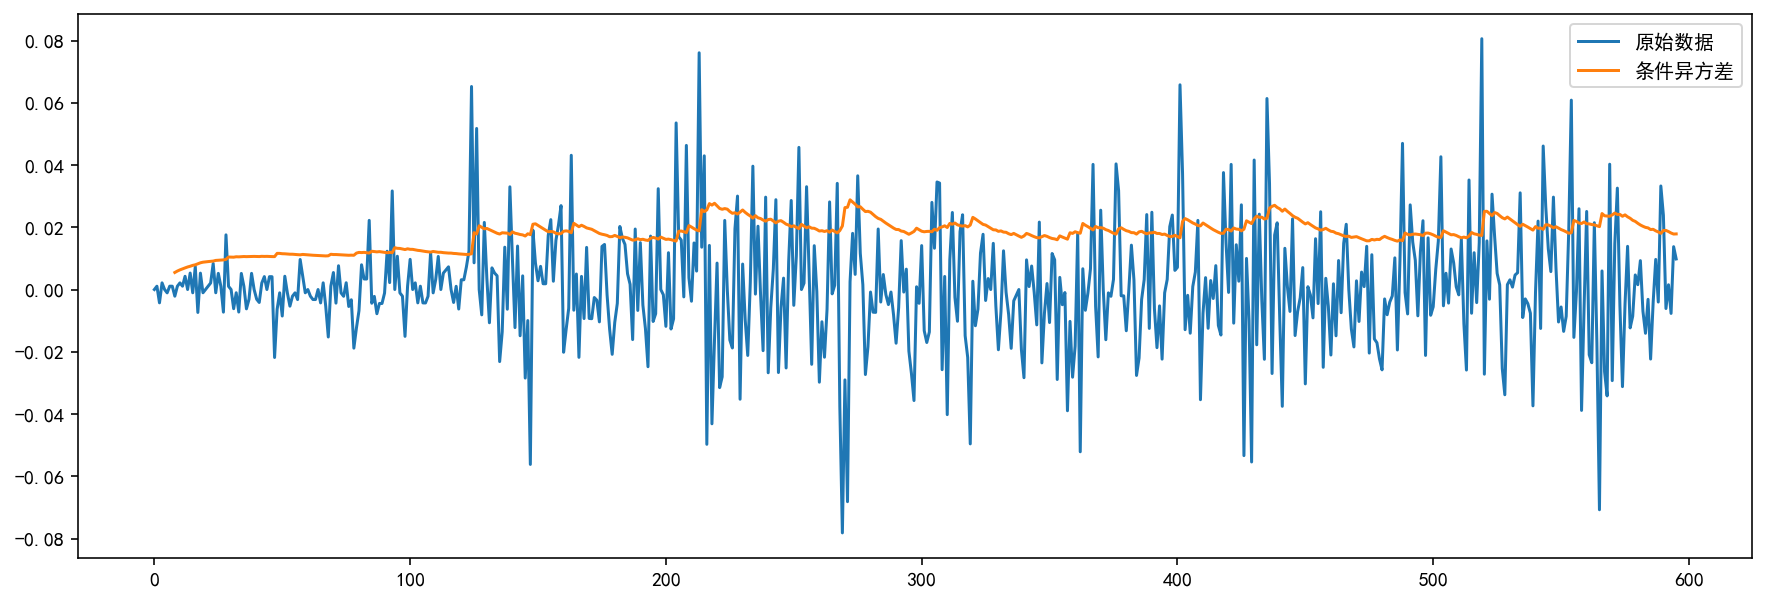

In [46]:
from scipy.special import gammaln
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm,t
import matplotlib.pyplot as plt
p = 0.01
phi =  norm(0,1).ppf(p)
plt.figure(figsize=(15,5))
plt.plot(temp,label='原始数据')
plt.plot(GARCH_res.conditional_volatility,label='条件异方差')
plt.legend(loc=0)

条件异方差: 0.017867541413838693; IDCF(0.01): -2.3263478740408408
在险价值_广义自回归条件异方差模型H: 407.1409184483721


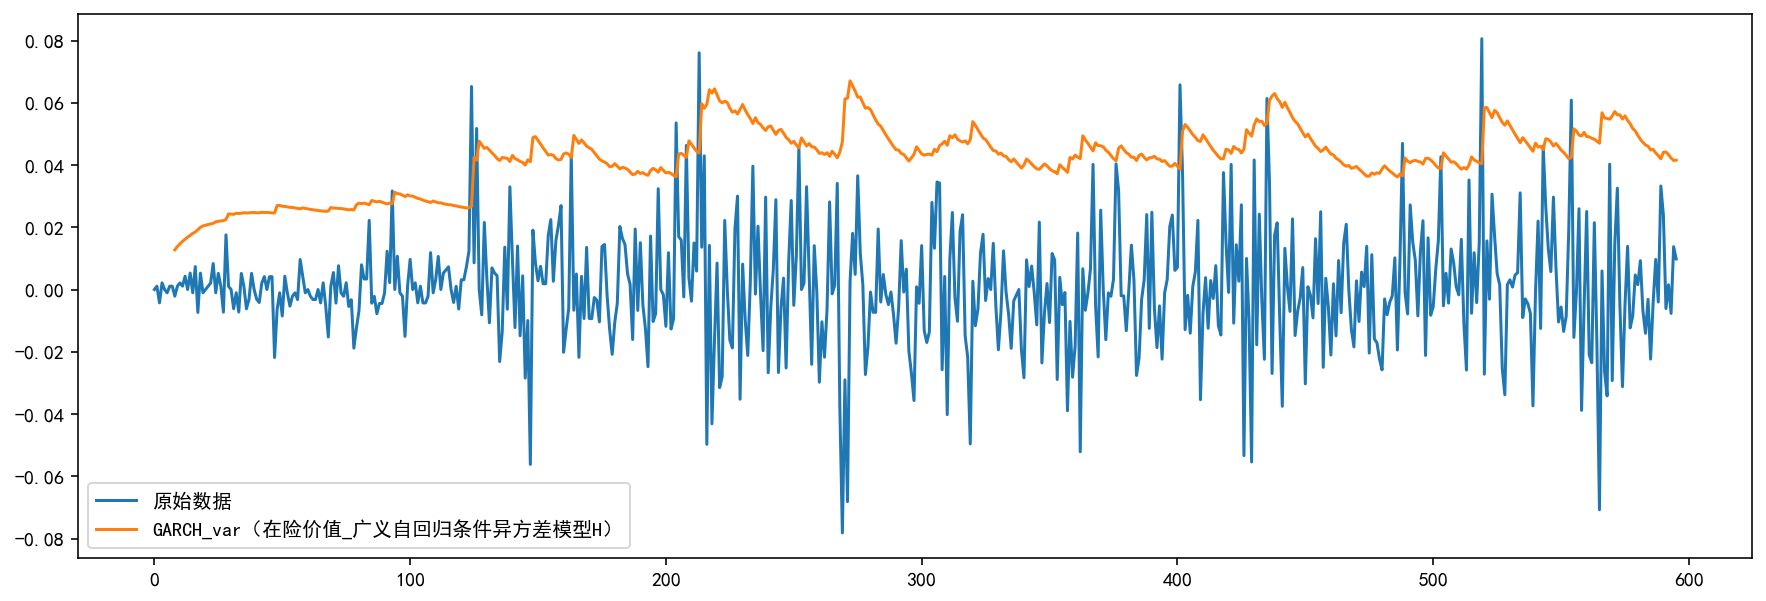

In [47]:
p = 0.01
phi =  norm(0,1).ppf(p)
plt.figure(figsize=(15,5))
plt.plot(temp,label='原始数据')
GARCH_var = -GARCH_res.conditional_volatility * phi
plt.plot(GARCH_var,label='GARCH_var（在险价值_广义自回归条件异方差模型H）')
plt.legend(loc=0)
print("条件异方差: %s; IDCF(0.01): %s" %(GARCH_res.conditional_volatility[-1], phi))
print("在险价值_广义自回归条件异方差模型H: %s" %(10000.0*(1-np.exp(-GARCH_var[-1]))))

In [49]:
data5 = pd.DataFrame()
data5["指数收益"] =StockPrices["LogReturns"]
data5 = data5.reset_index()
logarray = np.array(StockPrices["LogReturns"])

periodNum = 22 # 22 for month. 252 for year
for i in range(periodNum,len(logarray)): 
    data5.loc[i,'sigma_标准差'] = np.std(logarray[i-periodNum + 1:i])
data5 = data5[periodNum:]
data5 = data5.reset_index(drop=True)
data5['z_信噪比'] = data5['指数收益']/data5['sigma_标准差']
data5 = data5.dropna()
data5 = data5.reset_index(drop = True)
data5

,date,指数收益,sigma_标准差,z_信噪比
0,2017-02-09,0.001048,0.003184,0.329270
1,2017-02-10,0.002100,0.003181,0.660210
2,2017-02-13,0.008363,0.003193,2.618894
3,2017-02-14,-0.001044,0.003365,-0.310224
4,2017-02-15,0.005196,0.003400,1.528149
...,...,...,...,...
570,2019-06-12,-0.006103,0.017242,-0.353967
571,2019-06-13,0.001529,0.016041,0.095337
572,2019-06-14,-0.007675,0.015746,-0.487411
573,2019-06-17,0.013768,0.014068,0.978683


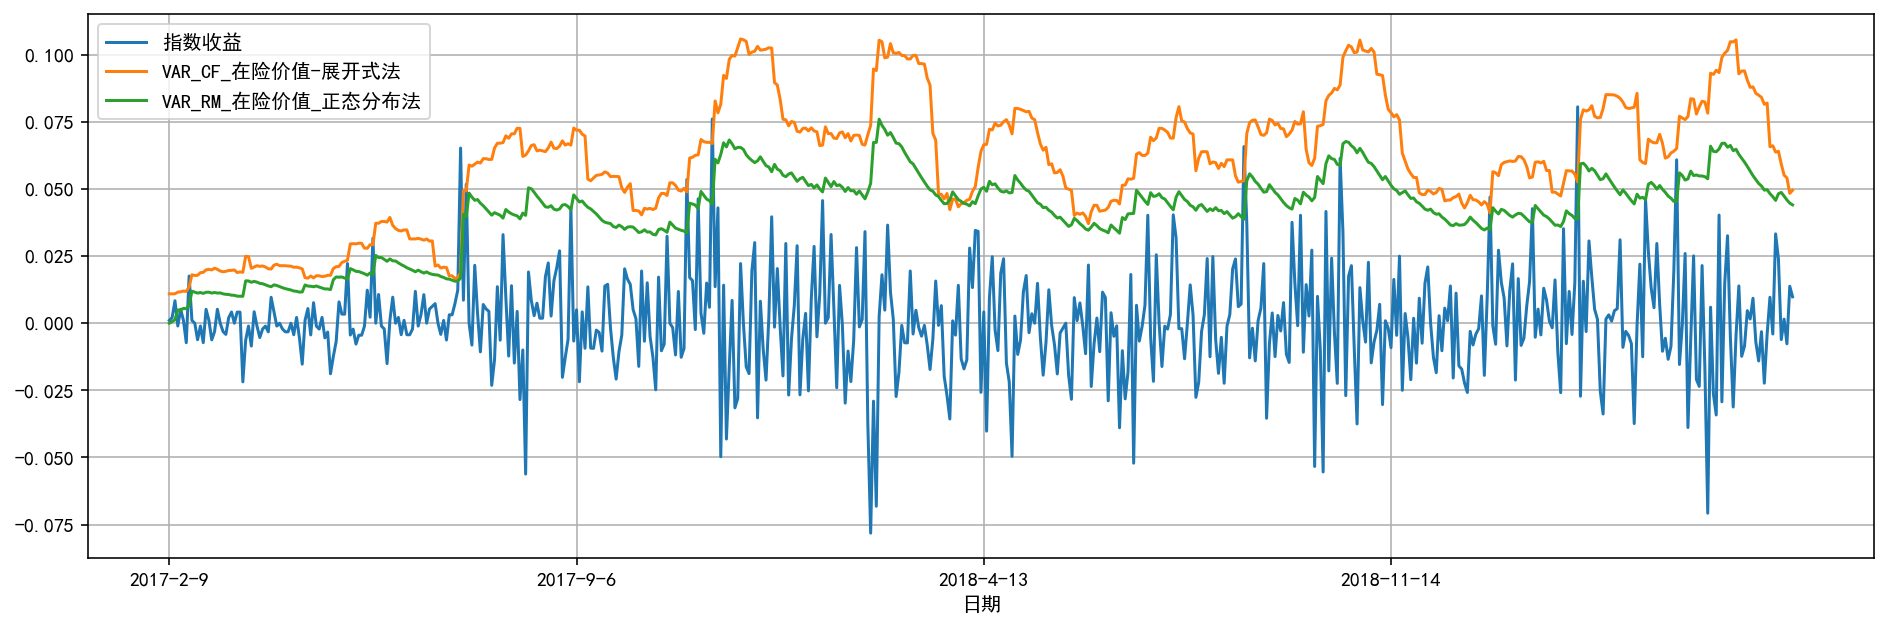

In [51]:
import pandas as pd 
import numpy as np
from scipy import optimize
from scipy.special import gammaln
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm,t
import matplotlib.pyplot as plt
p = 0.01
phi =  norm(0,1).ppf(p)
# data5['VAR_EVT'] = -data5['sigma']*u*(p/(Tu/T))**(-xi)
# data5['VAR_norm'] = - data5['sigma']*phi
# data5['VAR_t'] = - data5['sigma']*t(d_best[0]).ppf(p)*((d_best[0] - 2)/d_best[0])**0.5
data5['VAR_CF_在险价值_展开式法'] = - data5['sigma_标准差']*(phi + data5.z_信噪比.skew()/6*(phi**2-1) + \
                                    data5.z_信噪比.kurt()/24*(phi**3-3*phi) - data5.z_信噪比.skew()**2/36*(2*phi**3-5*phi))

data5['sigma2_RM'] = np.nan
data5.loc[0,'sigma2_RM'] = 0
for i in range(data5.shape[0] - 1):
    data5.loc[i + 1,'sigma2_RM'] = data5.loc[i,'sigma2_RM']*0.94 + 0.06*data5.loc[i,'指数收益']**2
data5['VAR_RM_在险价值_正态分布法'] = -data5['sigma2_RM']**0.5 * phi

xticklabel = data5.loc[:,'date'].apply(lambda x:str(x.year) + '-' +str(x.month) + '-' +str(x.day))
xticks = np.arange(0,data5.shape[0]+1,np.int((data5.shape[0]+1)/4))
X = np.arange(data5.shape[0])
plt.figure(figsize=(16,5))
SP = plt.axes()      
# plt.plot(X,data5.VAR_EVT,label = 'VAR_EVT')  
# plt.plot(X,data5.VAR_norm,label = 'VAR_EVT') 
plt.plot(X,data5.指数收益,label = '指数收益') 
plt.plot(X,data5.VAR_CF_在险价值_展开式法,label = 'VAR_CF_在险价值-展开式法') 
plt.plot(X,data5.VAR_RM_在险价值_正态分布法,label = 'VAR_RM_在险价值_正态分布法') 
SP.set_xticks(xticks)
SP.set_xticklabels(xticklabel[xticks])
plt.xlabel('日期')
plt.grid()
plt.legend()
plt.show()

In [52]:
#假设投入金融为一万美圆（$10000),那么最后一日，概率为1%的最大损失是
VAR_CF = 10000.0*(1-np.exp(-data5['VAR_CF_在险价值_展开式法']))
VAR_RM = 10000.0*(1-np.exp(-data5['VAR_RM_在险价值_正态分布法']))
print("$VAR_RM_在险价值_正态分布法: %s, $VAR_CF_在险价值_展开式法: %s" %(np.array(VAR_RM)[-1], np.array(VAR_CF)[-1]))

$VAR_RM_在险价值_正态分布法: 431.04358616531056, $VAR_CF_在险价值_展开式法: 483.1632925294094


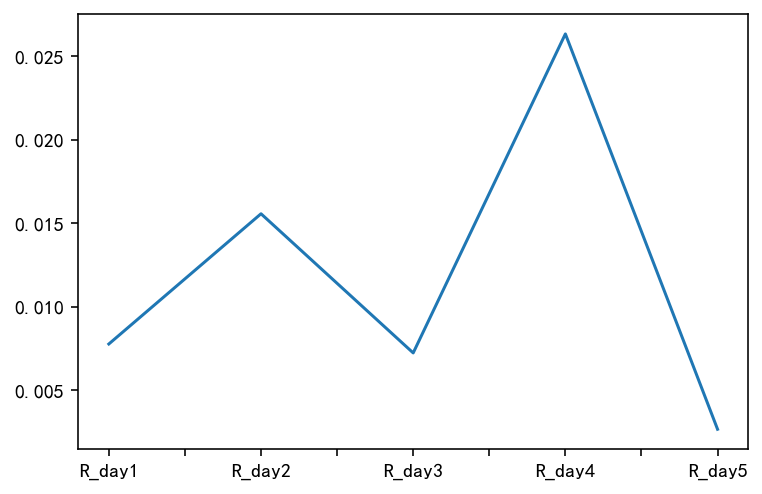

In [53]:
def VaR_Monte(num,p,mean, sigma_first,ndays):
    np.random.seed(4)
    MC = num
    sigma2_Garch = sigma_first**2
    data_MC = pd.DataFrame(index = range(MC))
    data_R = pd.DataFrame(index = range(MC))
    data_MC['z_day1'] =  np.random.normal(size = (num,1))
    data_R['R_day1'] = mean + sigma2_Garch**0.5 * data_MC['z_day1']
    data_MC['sigma2_day1'] =  0.000006 + 0.1*(data_R['R_day1'] - 1.37387691043997*sigma2_Garch**0.5)**2  +  0.88*sigma2_Garch

    # 低2-10天公式一样，循环
    for i in range(2,ndays +1):
        exec("data_MC['z_day" + str(i) + "'] = np.random.normal(size = (10000,1))")
        exec("data_R['R_day" + str(i) + "'] = data_MC['sigma2_day" + str(i-1) + "']**0.5 * data_MC['z_day" + str(i) + "']")
        exec("data_MC['sigma2_day" + str(i) + "'] = 0.00006 + 0.1*(data_R['R_day" + str(i) + "'] - 1.37387691043997*data_MC['sigma2_day" + str(i -1) + "']**0.5)**2 + 0.88*data_MC['sigma2_day" + str(i-1) + "']")
    VaR = pd.DataFrame(index = range(ndays))

    for i in range(ndays):
        R_ndays = data_R.iloc[:,:i+1].sum(axis = 1)
        VaR.loc[i,'VaR'] = - np.percentile(R_ndays,p) 
    
    if ndays > 1:
        data_R.loc[1,:].plot()
    else:
#         data_R['R_day1'].plot()
        plt.hist(data_R['R_day1'], bins=75, alpha=0.7, density=True)
    return VaR


p = 0.01
num = 10000
mean = np.mean(data5.指数收益[-252:])
sigma_first = 0.01379305642901181
ndays =5

VaR=VaR_Monte(num,p,mean,sigma_first,ndays)

In [54]:
VAR_F = 10000.0*(1-np.exp(-VaR))
print("VAR_CF_在险价值_展开式法: %s" %np.array(VAR_F)[-1])

VAR_CF_在险价值_展开式法: [1938.41672083]
